In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import random

In [2]:
df = pd.read_csv('nacas.csv')
NACAS = ['4415','4412','6412','2411']
df = df.loc[(df['naca'] == '4415') | (df['naca'] == '4412') | (df['naca'] == '6412') | (df['naca'] == '2411')]

In [3]:
def Cx_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CD'])

def Cz_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CL'])

def Alpha_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['alpha'])

Text(0.5, 1.0, 'Cz 4412 discret')

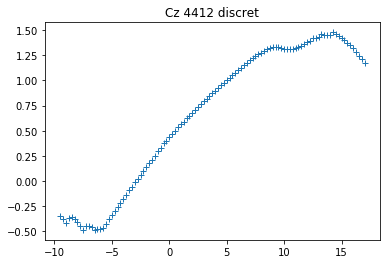

In [4]:
x = Alpha_data('4412', 100000)
y = Cz_data('4412',100000)
plt.plot(x,y,"+")
plt.title('Cz 4412 discret')

In [5]:
spl = InterpolatedUnivariateSpline(x, y, k=5)

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

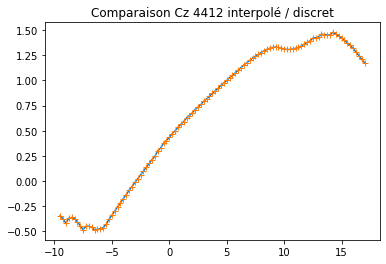

In [6]:
plt.plot(x,spl(x))
plt.plot(x,y,"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

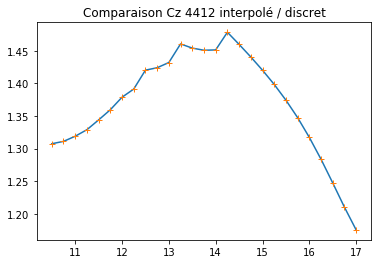

In [7]:
plt.plot(x[80:],spl(x[80:]))
plt.plot(x[80:],y[80:],"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

In [8]:
def Cx_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cx_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5)
    return spl

def Cz_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cz_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5)
    return spl

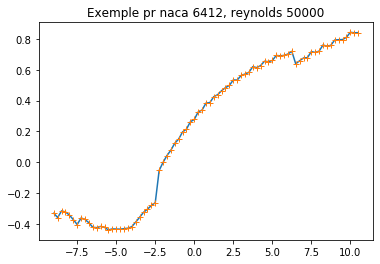

In [9]:
plt.title('Exemple pr naca 6412, reynolds 50000')
plt.plot(Alpha_data('6412',50000),Cz_spline('6412',50000)(Alpha_data('6412',50000)))
plt.plot(Alpha_data('6412',50000),Cz_data('6412',50000),"+")

In [10]:
## INUTILE :

def make_theta(delta):
    def theta(x,args):
        ind = int(x//delta)
        if 0<= x <= delta:
            return args[0]+x*args[1]
        elif x == ind*delta:
            return args[ind]*delta + theta((ind-1)*delta,args)
        else:
            return args[ind+1]*(x-ind*delta)+theta(ind*delta,args)
    return theta

def make_c(delta):
    def c(x,args):
        ind = int(x//delta)
        if 0<= x <= delta:
            return args[0]+x*args[1]
        elif x == ind*delta:
            return args[ind]*delta + c((ind-1)*delta,args)
        else:
            return args[ind+1]*(x-ind*delta)+c(ind*delta,args)
    return c

In [11]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time

In [12]:
import numpy.polynomial.polynomial as nppol

In [241]:
def simu(naca = '4412', N_elements = 50, r_min = 0.01, r_max = 0.07):

    # Créations des fonctions continues Cx, Cz
    func_Cx = dict()
    func_Cz = dict()
    for reynolds in [50000, 100000, 200000, 500000, 1000000]:
        func_Cx[str(reynolds)] = Cx_spline(naca, reynolds)
        func_Cz[str(reynolds)] = Cz_spline(naca, reynolds)

    # Discrétisation des rayons
    rayons = np.linspace(r_min, r_max, N_elements)

    # Calcul du pas associé
    delta = rayons[1]-rayons[0]

    n = 10000/60

    # Fonction de vitesse
    def speed(r,n):
        return 2*np.pi*r*n

    # Fonction de surface d'un trapèze
    def area(l1, l2):
        return (l1+l2)/2 * delta

    # Plus proche voisin d'un élément dans une liste

    def NN(element, L):
        l = len(L)
        cand = 0
        tol = np.abs(L[cand])+np.abs(element)
        for k in range(l):
            if np.abs(L[k]-element)<tol:
                cand = k
                tol = np.abs(L[k]-element)
        return cand

    # Fonction qui associe le Reynolds le plus proche du vrai Reynolds :

    def Reynolds(vitesse, L_c):
        mu = 1.56 * 10**-5
        all_reys = [50000,100000,500000,1000000]
        return all_reys[NN(L_c*vitesse/mu, all_reys)]

    # Calcul du Cx, Cz pour une géométrie donnée : 

    def C_global(thetas, chords):
        sz = 0
        sx = 0
        div = 0
        for i in range(N_elements):
            v_i = speed(rayons[i], n)

            if i == N_elements-1:
                S_i = area(chords[i-1], chords[i])
            else:
                S_i = area(chords[i], chords[i+1])

            reynolds = Reynolds(v_i, chords[i])

            C_x = func_Cx[str(reynolds)]
            sx+= v_i**2 * S_i * C_x(thetas[i])

            C_z = func_Cz[str(reynolds)]
            sz+= v_i**2 * S_i * C_z(thetas[i])

            div+= v_i**2 * S_i

        return sz/div, sx/div

    # Calcul du Cx induit pour une géométrie donnée :
    
    def C_induit(thetas, chords, Cz):
        e = 0.8
        S_tot = 0
        for i in range(N_elements-1):
            c_i = chords[i]
            c_i2 = chords[i+1]
            S_tot+=area(c_i,c_i2)

        allongement = (r_max - r_min)**2 / S_tot

        return Cz**2/(np.pi * allongement * e)

    # Calcul de la puissance de trainee (contrainte) :

    #TODO faire par éléments et pas juste une putain de surface globale ==> sinon ça arrondit sans aucune race l'hélice
    def puissance_trainee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        P_tot = 0
        pho_air = 1.3
        S_tot = 0
        for i in range(N_elements-1):
            v_i = speed(rayons[i], n)
            S_i=area(chords[i],chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_x = func_Cx[str(reynolds)]
            Cx_loc = f_C_x(thetas[i])
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cx_loc * S_i
            S_tot += S_i
        Cz, Cx = C_global(thetas, chords)
        C_xi = C_induit(thetas,chords, Cz)
        v_moy = np.mean(speed(rayons,n))
        P_tot += 2 * 1/2 * pho_air * v_moy**3 * C_xi * S_tot
        print(P_tot)
        return P_tot + 20

    def force_poussée(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)

        F_tot = 0

        pho_air = 1.3

        Cx, Cz = C_global(thetas, chords)
        C_xi = C_induit(thetas, chords, Cz)

        for i in range(N_elements-1):
            v_i = speed(rayons[i], n)
            S_i = area(chords[i], chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz = f_C_z(thetas[i])

            F_tot+= 1/2 * pho_air * v_i**2 * S_i * Cz

        return F_tot

    def fonction_vrillage(args):
        return args[2] * rayons**2 + args[1] * rayons + args[0]
    
    def fonction_corde(args):
        return args[5] * rayons**2 + args[4] * rayons + args[3]

    def func2optim(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        Cz, Cx = C_global(thetas, chords)
        C_xi = C_induit(thetas,chords, Cz)
        return -Cz /(Cx+C_xi)

    # Création de la contrainte :

    cons1 = NonlinearConstraint(puissance_trainee, 0, 60)

    cons2 = NonlinearConstraint(fonction_corde,np.ones(N_elements)*0.01,np.ones(N_elements)*0.05)

    cons3 = NonlinearConstraint(fonction_vrillage,np.zeros(N_elements),np.ones(N_elements)*20)

    cons4 = NonlinearConstraint(force_poussée, 0.5*9.81/8, np.infty)

    # Initialisation des coefficients : 

    poly_vrillage_0 = [3,-3/r_max,0]

    #poly_corde_0 = [ 7.e-04, -8.e-02,  1.e+00]
    poly_corde_0 = [0.03,0,0]

    x_init = np.array(poly_vrillage_0+poly_corde_0)

    # Exécution de l'optimisation :

    t_0 = time.time()

    res = minimize(func2optim, x0 = x_init, constraints = [cons1,cons2,cons3,cons4], tol = 10**-20)

    print(f'Run in {int(time.time()-t_0)}')
    print(res['success'], res['nit'])
    return rayons, res

In [242]:
rayons, res = simu()

13.39056922793256
13.39056942114759
13.39056908093269
13.390569228127424
13.39057997824748
13.390569692518197
13.390569251159963
13.39056922793256
13.39056922793256
13.39056922793256
13.39056929233757
13.390569231362559
13.390569228127424
13.39057997824748
13.390569692518197
13.390569251159963
5.130360158239102
8.751940725346362
8.751940725346362
8.751940760594703
8.751940727215073
8.751940725451952
8.751949033062317
8.751941098735792
8.751940744559779
5.390705169349035
7.143715860217943
7.143715860217943
7.143715885082289
7.143715861530938
7.143715860291588
7.143723219918051
7.143716199342524
7.143715877918136
5.806679750687192
6.401496521291785
6.401496521291785
6.401496541386317
6.401496522355615
6.401496521351344
6.40150349216904
6.40149684676045
6.401496538389111
0.9124506078697909
0.9124506078697909
0.9124506187248604
0.9124506081966184
0.912450607878498
0.9124536791991829
0.9124508656595693
0.9124506254097833
9295.614274313213
9295.614274313213
9295.614674412023
9295.61428530791

In [243]:
res['x']

array([ 9.10938557e+00, -4.20043160e-01,  4.37545942e+00,  1.00000110e-02,
       -2.18814811e-08,  3.07617324e-07])

In [244]:
rayons = np.linspace(0.01, 0.07, 50)

In [245]:
def fonction_vrillage(r, args):
    return args[2]* r**2 + args[1] * r + args[0]

In [246]:
def fonction_corde(r,args):
    return args[5]*r**2 + args[4] * r + args[3]

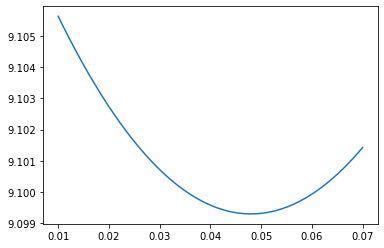

In [247]:
plt.plot(rayons,fonction_vrillage(rayons, res['x']))

(0.006999999999999999,
 0.07300000000000001,
 0.010000010590579042,
 0.010000010991786054)

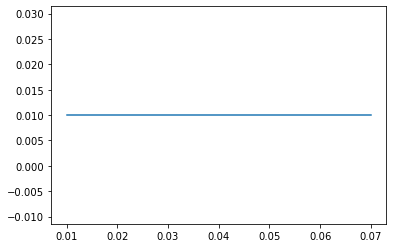

In [248]:
plt.plot(rayons,fonction_corde(rayons, res['x']))
plt.axis('equal')

In [120]:
res['x']

array([ 4.89232001e+00, -6.96880907e+01, -2.88469329e+00,  7.67395294e-03,
        2.33982832e-01, -7.57191716e-02])

In [54]:
for naca in NACAS:
    print(naca,np.max(Alpha_data(naca, 50000)))

4415 11.5
4412 14.0
6412 10.5
2411 12.75


In [57]:
(2*np.pi*0.025*10000/60)

26.17993877991494